`ECML PKDD 2024 Tutorial / An Introduction to Machine Learning from Time Series`

# Part 2: Classification and Regression for Time Series

This is the notebook for the time series classification (TSC) and regression (TSER) portion of the "An Introduction to Machine Learning from Time Series" tutorial at [ECML PKDD 2024](https://ecmlpkdd.org/2024/). The tutorial website is [here](https://aeon-tutorials.github.io/ECML-2024/).

<img src="./img/classification.png" alt="Time series classification."><i>

<img src="./img/regression.png" alt="Time series extrinsic regression."><i>

## Table of Contents <a id='toc'></a>

* [`aeon` toolkit for TSC and TSER](#intro)
* [Load example datasets](#load-data)
* [Basic estimator workflow](#basics)
* [Distance-based](#distance)
* [Feature-based](#feature)
* [Interval-based](#interval)
* [Shapelet-based](#shapelet)
* [Convolution-based](#convolution)
* [Dictionary-based](#dictionary)
* [Deep learning](#deep)
* [Hybrids](#hybrid)
* [Benchmarking](#benchmark)
* [Interfacing with `scikit-learn` utilities](#sklearn)
* [Further information](#further)

You can run the below cell to install the required packages for this notebook and download the regression dataset. `torch` and `tensorflow` are bulky can be removed to reduce install time, but some cells will not be able to run.

In [ ]:
!pip install aeon==0.11.1 matplotlib seaborn tsfresh torch tensorflow
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TRAIN.ts -P data/
!wget -nc https://raw.githubusercontent.com/aeon-tutorials/KDD-2024/main/Notebooks/data/KDD_UTSER_TEST.ts -P data/

In [1]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for
# aeon there will be big changes in our v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")

## `aeon` toolkit for TSC and TSER <a id='intro'></a>

The tutorial uses the `aeon` toolkit for machine learning from time series data. `aeon` is a `scikit-learn` compatible toolkit for time series machine learning (TSML). We focus on the `classification` and `regression` modules. These are split into submodules for each of the algorithm types we have introduced: `distance_based`, `feature_based`, `interval_based`, `shapelet_based`, `convolution_based`, `dictionary_based`, `deep_learning`, and `hybrid`.

If you are interested in more content, we recommend looking at the notebooks produced for our [KDD 2024 tutorial](https://aeon-tutorials.github.io/KDD-2024/). There is a notebook for each algorithm type we will cover in this tutorial, which goes into more detail on the algorithms and how to use them. We will link each of these notebooks in the relevant sections below. The introduction notebook for the KDD tutorial is available on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part1_introduction.ipynb) or [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part1_introduction.ipynb).

At any point if you have questions, please feel free to join our [Slack](https://join.slack.com/t/aeon-toolkit/shared_invite/zt-22vwvut29-HDpCu~7VBUozyfL_8j3dLA) and ask (a link is available here and on the `aeon` README). 

## Load example datasets <a id='load-data'></a>

Classifiers and regressors take input collections of time series (and inherit from `BaseCollectionEstimator`). If the series are all equal length, this works best with 3D numpy shape `(n_cases, n_channels, n_timepoints)`. As we only use univariate data in this example, `n_channels` will be 1. Unequal length series are stored in lists of 2D numpy, but the examples we are going to use will be equal length.

This tutorial will use the GunPoint dataset for classification and an EEG example dataset for regression. In GunPoint the goal is to classify whether a person is drawing a gun or pointing using the centroid of the actors right hand.

`aeon` ships with some standard UCR, UEA and Monash datasets including the ones we use. You can download them all directly from [timeseriesclassification.com](https://timeseriesclassification.com) or [tseregression.org](http://tseregression.org/). Please do not over interpret any results from these datasets; they are simple example problems to demonstrate the functionality of our implementations.

In [2]:
from aeon.datasets import load_gunpoint

X_train_clf, y_train_clf = load_gunpoint("train")
X_test_clf, y_test_clf = load_gunpoint("test")

print("GunPoint train shape:", X_train_clf.shape)
print("GunPoint test shape:", X_test_clf.shape)

GunPoint train shape: (50, 1, 150)
GunPoint test shape: (150, 1, 150)


In [3]:
from aeon.datasets import load_from_tsfile

X_train_reg, y_train_reg = load_from_tsfile("./data/KDD_UTSER_TRAIN.ts")
X_test_reg, y_test_reg = load_from_tsfile("./data/KDD_UTSER_TEST.ts")

print("EEG train shape:", X_train_reg.shape)
print("EEG test shape:", X_test_reg.shape)

EEG train shape: (72, 1, 100)
EEG test shape: (72, 1, 100)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

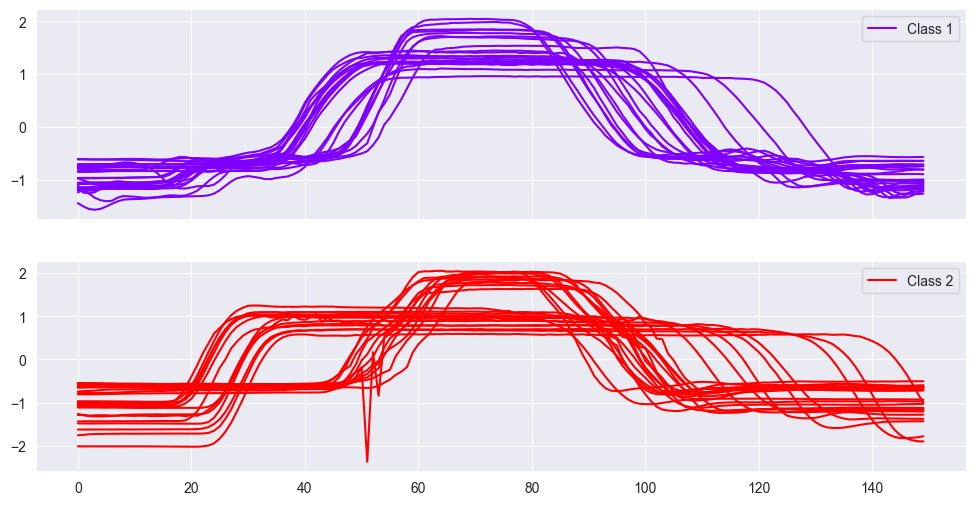

In [4]:
from aeon.visualisation.series._collections import plot_collection_by_class

plot_collection_by_class(X_train_clf, y_train_clf)

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

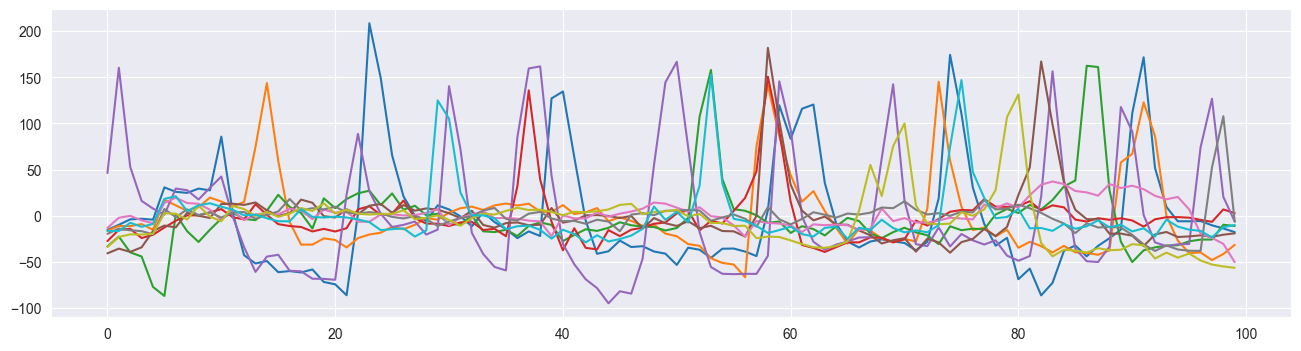

In [5]:
from aeon.visualisation.series._collections import plot_series_collection

plot_series_collection(X_train_reg[:10,:,:])

## Basic estimator workflow <a id='basics'></a>

`aeon` follows the `scikit-learn` interface. Classifier and regressor classes can be built using `fit`, and then prediction for new cases can be made using `predict`. `predict_proba` is available for classifiers, to output probability estimated. `score` is available for both classifiers and regressors. Classifiers return accuracy, regressors return R^2 by default.

In [6]:
from aeon.classification import DummyClassifier

dclf = DummyClassifier(strategy="uniform", random_state=42)
dclf.fit(X_train_clf, y_train_clf)

DummyClassifier(random_state=42, strategy='uniform')

In [7]:
dclf.predict(X_test_clf)

array(['1', '2', '1', '1', '1', '2', '1', '1', '1', '2', '1', '1', '1',
       '1', '2', '1', '2', '2', '2', '1', '2', '1', '2', '2', '2', '2',
       '2', '2', '2', '2', '1', '1', '2', '2', '2', '1', '2', '1', '1',
       '1', '1', '1', '2', '2', '2', '2', '2', '1', '2', '2', '1', '2',
       '1', '2', '1', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1',
       '2', '2', '1', '2', '2', '2', '2', '1', '2', '1', '2', '2', '2',
       '1', '2', '1', '2', '1', '2', '1', '1', '2', '1', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '1', '1', '2', '2', '2',
       '2', '2', '2', '2', '2', '1', '2', '1', '2', '2', '1', '2', '1',
       '2', '2', '1', '2', '1', '2', '1', '1', '2', '2', '1', '2', '2',
       '2', '1', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '2',
       '2', '2', '1', '1', '1', '1', '2'], dtype='<U1')

In [8]:
dclf.predict_proba(X_test_clf)

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5,

In [9]:
dclf.score(X_test_clf, y_test_clf)

0.4666666666666667

In [10]:
from aeon.regression import DummyRegressor

dreg = DummyRegressor(strategy="median")
dreg.fit(X_train_reg, y_train_reg)

DummyRegressor(strategy='median')

In [11]:
dreg.predict(X_test_reg)

array([2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875, 2.38898875, 2.38898875, 2.38898875,
       2.38898875, 2.38898875])

In [12]:
dreg.score(X_test_reg, y_test_reg)

-0.03816762638093052

## Distance-based <a id='distance'></a>

Similarity-based approaches were one of the first proposals for tackling the classification and regression of time series. This section introduces the Dynamic Time Warping (DTW) distance from the `distances` module, and then showcases the distance-based estimators available in `aeon`.

You can find more information on distance-based approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part2_distance_based.ipynb) or [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part2_distance_based.ipynb).

In [13]:
from aeon.registry import  all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "distance"}, as_dataframe=True
)

,name,estimator
0,ElasticEnsemble,<class 'aeon.classification.distance_based._el...
1,KNeighborsTimeSeriesClassifier,<class 'aeon.classification.distance_based._ti...
2,ProximityForest,<class 'aeon.classification.distance_based._pr...
3,ProximityTree,<class 'aeon.classification.distance_based._pr...


In [14]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "distance"}, as_dataframe=True
)

,name,estimator
0,KNeighborsTimeSeriesRegressor,<class 'aeon.regression.distance_based._time_s...


### Dynamic Time Warping (DTW)

DTW is an elastic distance measure that allows for the comparison of time series. We briefly introduce its implementation in `aeon` here. We generate two random time series, then calculate the DTW distance between them with a warping window of 10%.

In [15]:
from aeon.testing.data_generation import make_example_1d_numpy

from aeon.distances import dtw_distance

a = make_example_1d_numpy(n_timepoints=10, random_state=0)
b = make_example_1d_numpy(n_timepoints=10, random_state=1)

dtw_distance(a, b, window=0.1)

1.1985498275436108

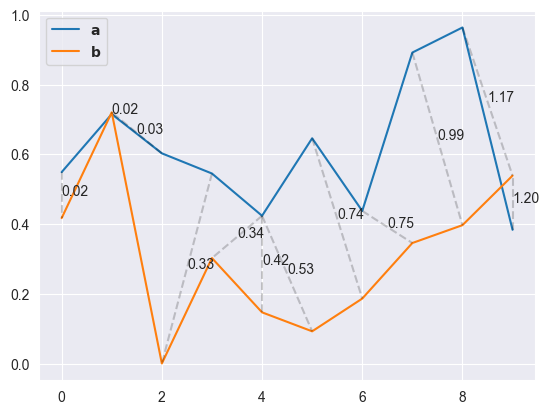

In [16]:
from aeon.distances import dtw_alignment_path, dtw_cost_matrix
import seaborn as sns
import matplotlib.pyplot as plt

path, _ = dtw_alignment_path(a, b, window=0.1)
cost_matrix = dtw_cost_matrix(a, b, window=0.1)

sns.lineplot(data=a, label=r"$\mathbf{a}$")
sns.lineplot(data=b, label=r"$\mathbf{b}$")

# join the points in the path
for i in range(len(path)):
    plt.plot([path[i][0], path[i][1]], [a[path[i][0]], b[path[i][1]]], 'k--', alpha=0.2)
    plt.text(
        (path[i][0]+path[i][1])/2,
        (a[path[i][0]]+b[path[i][1]])/2,
        f"{cost_matrix[path[i][0], path[i][1]]:.2f}"
    )

plt.show()

<Axes: >

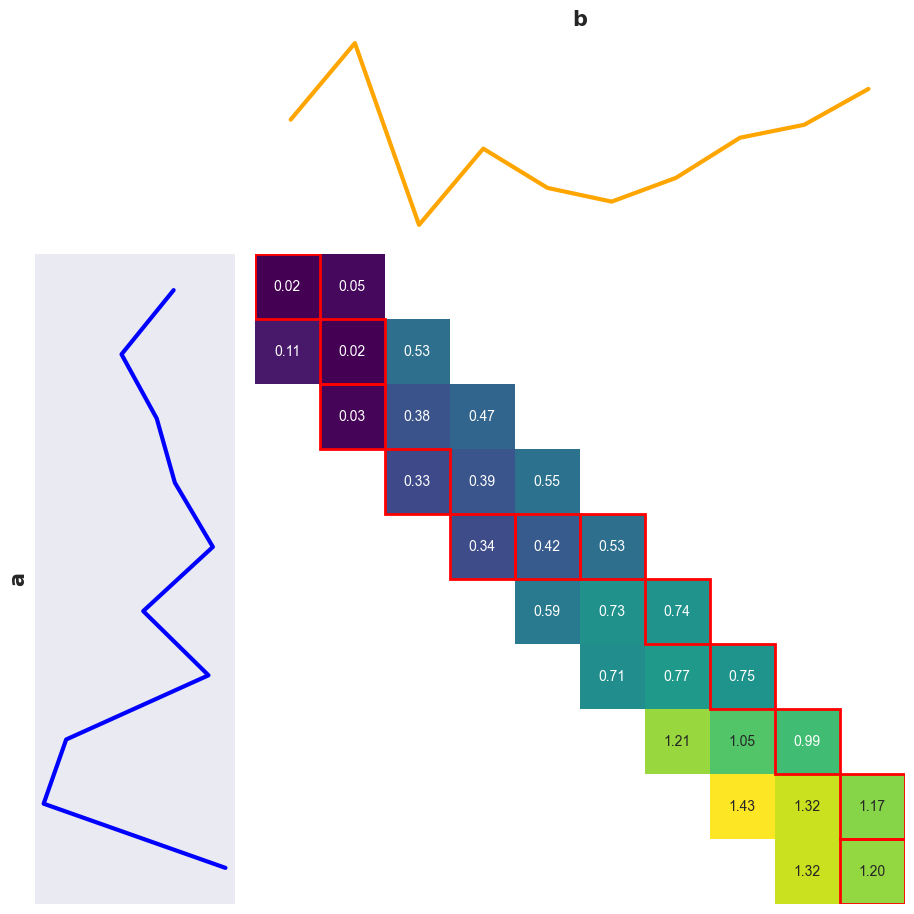

In [17]:
from aeon.visualisation.distances._pairwise_distance_matrix import plot_pairwise_distance_matrix

plot_pairwise_distance_matrix(cost_matrix, a, b, path)

### Distance-based classifiers and regressors

We will now demonstrate the use of distance-based classifiers and regressors in `aeon`. The most basic apprach are the nearest neighbour classes in `KNeighborsTimeSeriesClassifier` and `KNeighborsTimeSeriesRegressor`. These classes use the DTW distance by default, but can be set to use other distances from the `distances` module.

In [18]:
from aeon.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score

knn_clf = KNeighborsTimeSeriesClassifier(
    n_neighbors=1, 
    distance="dtw", 
    distance_params={"window": 0.1}
)
knn_clf.fit(X_train_clf, y_train_clf)
knn_clf_pred = knn_clf.predict(X_test_clf)
accuracy_score(y_test_clf, knn_clf_pred)

0.94

In [19]:
from aeon.regression.distance_based import KNeighborsTimeSeriesRegressor
from sklearn.metrics import mean_squared_error

knn_reg = KNeighborsTimeSeriesRegressor(
    n_neighbors=1,
    distance="dtw",
    distance_params={"window": 0.1}
)
knn_reg.fit(X_train_reg, y_train_reg)
knn_reg_pred = knn_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, knn_reg_pred)

1.5748490017324903

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

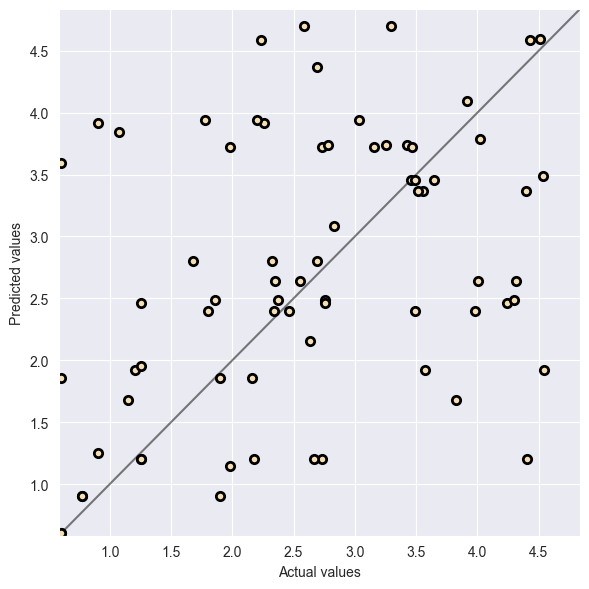

In [20]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, knn_reg_pred)

`aeon` also has implementation of distance-based ensembles for classification in the `ElasticEnsemble` and `ProximityForest` classes, which use multiple distance measures to classify time series.

In [21]:
from aeon.classification.distance_based import ElasticEnsemble
from sklearn.metrics import accuracy_score

ee = ElasticEnsemble(
    distance_measures=["dtw", "wdtw", "msm"],
    proportion_of_param_options=0.1,
    proportion_train_in_param_finding=0.1,
    proportion_train_for_test=0.1,
    random_state=42,
)
ee.fit(X_train_clf, y_train_clf)
ee_pred = ee.predict(X_test_clf)
accuracy_score(y_test_clf, ee_pred)

0.9533333333333334

In [22]:
from aeon.classification.distance_based import ProximityForest
from sklearn.metrics import accuracy_score

pf = ProximityForest(n_trees=10, random_state=42)
pf.fit(X_train_clf, y_train_clf)
pf_pred = pf.predict(X_test_clf)
accuracy_score(y_test_clf, pf_pred)

0.9933333333333333

## Feature-based <a id='feature'></a>

Feature-based classifiers and regressors are a popular theme in time series classification and regression. The feature-based learners we provide are simply pipelines of transform and classifier/regressor. They extract descriptive statistics as features from time series to be used in a base estimator. In this section we will demonstrate the feature set estimators available in `aeon`.

You can find more information on feature-based approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part4_feature_based.ipynb) and [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part4_feature_based.ipynb).

<img src="./img/pipeline.png" alt="Pipeline classifier."><i>

In [23]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "feature"}, as_dataframe=True
)

,name,estimator
0,Catch22Classifier,<class 'aeon.classification.feature_based._cat...
1,FreshPRINCEClassifier,<class 'aeon.classification.feature_based._fre...
2,SignatureClassifier,<class 'aeon.classification.feature_based._sig...
3,SummaryClassifier,<class 'aeon.classification.feature_based._sum...
4,TSFreshClassifier,<class 'aeon.classification.feature_based._tsf...


In [24]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "feature"}, as_dataframe=True
)

,name,estimator
0,Catch22Regressor,<class 'aeon.regression.feature_based._catch22...
1,FreshPRINCERegressor,<class 'aeon.regression.feature_based._fresh_p...
2,SummaryRegressor,<class 'aeon.regression.feature_based._summary...
3,TSFreshRegressor,<class 'aeon.regression.feature_based._tsfresh...


### Feature transformations

While we mainly focus on the classification and regression classes, classes which just transform series into feature sets are also available in `aeon.transformations.collection.feature_based`. One of the most basic feature transformations is the `SevenNumberSummaryTransformer`, which calculates seven basic summary statistics from a time series.

In [25]:
from aeon.transformations.collection.feature_based import SevenNumberSummaryTransformer

sns = SevenNumberSummaryTransformer()
sns.fit_transform(X_train_clf)[:5]

array([[-4.00000006e-10,  9.96661092e-01, -7.82460830e-01,
         1.84581130e+00, -6.58057655e-01, -6.39051710e-01,
         7.85012235e-01],
       [-7.39999996e-10,  9.96661091e-01, -8.14203290e-01,
         1.92517670e+00, -6.43350263e-01, -6.09387320e-01,
         7.19289915e-01],
       [-1.89333333e-09,  9.96661090e-01, -7.82671580e-01,
         1.70373850e+00, -7.39111338e-01, -5.98165460e-01,
         1.09657273e+00],
       [ 1.58666668e-09,  9.96661095e-01, -7.92305130e-01,
         1.78327800e+00, -7.41087950e-01, -5.59941645e-01,
         8.50965877e-01],
       [ 2.40000001e-09,  9.96661097e-01, -7.33464510e-01,
         2.05336730e+00, -5.99016418e-01, -5.73589585e-01,
         4.71033785e-01]])

### Feature-based classifiers and regressors

Feature-based estimators are available for both classification and regression, but we will focus on classification for the most part. Catch22 and TSFresh are two popular features sets for time series available in `aeon`.

Catch22 is a set of 22 features that are designed to be fast to compute and informative for time series classification. It is available in the `Catch22Classifier` and `Catch22Regressor` classes which use a Random Forest by default.

<img src="./img/catch22.png" alt="TSFresh logo."><i>

In [26]:
from aeon.classification.feature_based import Catch22Classifier
from sklearn.metrics import accuracy_score

c22 = Catch22Classifier(random_state=42)
c22.fit(X_train_clf, y_train_clf)
c22_pred = c22.predict(X_test_clf)
accuracy_score(y_test_clf, c22_pred)

0.9533333333333334

TSFresh is a feature set containing over 700 features for time series. It comes in-built with feature selection for both classification and regression. It is available in the `TSFreshClassifier` and `TSFreshRegressor` classes which use a Random Forest by default.

A more optimised for accuracy version is available in the `FreshPRINCEClassifier` and `FreshPRINCERegressor` classes, which uses the full feature set with no feature selection and a Rotation Forest base estimator.

__Note:__ TSFresh estimators are implemented using `tsfresh`. You will need to `pip install tsfresh` to run this code.

<img src="./img/tsfresh.png" alt="TSFresh logo."><i>

In [27]:
from aeon.classification.feature_based import TSFreshClassifier
from sklearn.metrics import accuracy_score

tsfr = TSFreshClassifier(random_state=42)
tsfr.fit(X_train_clf, y_train_clf)
tsfr_pred = tsfr.predict(X_test_clf)
accuracy_score(y_test_clf, tsfr_pred)

0.9533333333333334

In [28]:
from aeon.classification.feature_based import FreshPRINCEClassifier
from sklearn.metrics import accuracy_score

fp_clf = FreshPRINCEClassifier(n_estimators=50, random_state=42)
fp_clf.fit(X_train_clf, y_train_clf)
fp_clf_pred = fp_clf.predict(X_test_clf)
accuracy_score(y_test_clf, fp_clf_pred)

0.92

In [29]:
from aeon.regression.feature_based import FreshPRINCERegressor
from sklearn.metrics import mean_squared_error

fp_reg = FreshPRINCERegressor(n_estimators=50, random_state=42)
fp_reg.fit(X_train_reg, y_train_reg)
fp_reg_pred = fp_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, fp_reg_pred)

0.8001021535971852

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

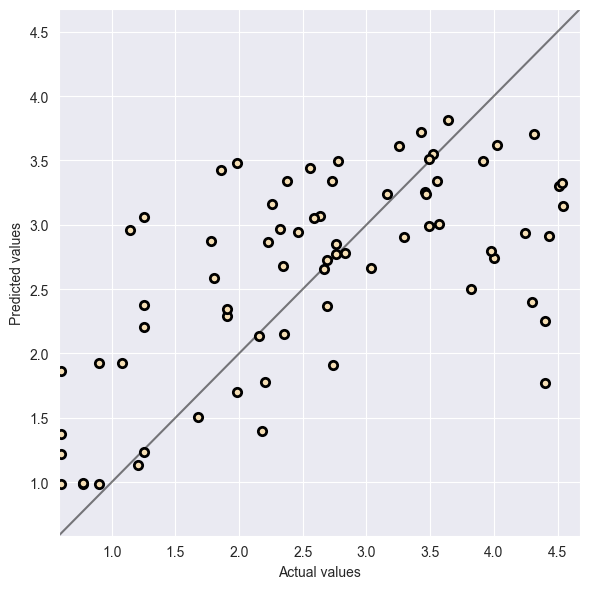

In [30]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, fp_reg_pred)

## Interval-based <a id='interval'></a>

Interval-based approaches look at phase-dependent intervals of the full series, calculating summary statistics from selected subseries to be used in classification and regression. Interval-based approaches are particularly useful when the phase of the time series is important for the classification or regression task. Depending on the features extracted, interval-based approaches can be more resistant to noise than other phase-dependent approaches. For example, in the case of the ethanol level series below, the phase of the signal is important for determining the level of ethanol in a bottle of alcohol. A large amount of irrelevant high variation noise is present which would confound approaches such as distance-based.

In this section, we will demonstrate how to use two of the interval-based estimators available in `aeon`: DrCIF and QUANT.

You can find more information on interval-based approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part5_interval_based.ipynb) and [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part5_interval_based.ipynb).

<img src="./img/interval.png" alt="Ethanol level series with the discriminatory interval highlighted."><i>

In [31]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "interval"}, as_dataframe=True
)

,name,estimator
0,CanonicalIntervalForestClassifier,<class 'aeon.classification.interval_based._ci...
1,DrCIFClassifier,<class 'aeon.classification.interval_based._dr...
2,IntervalForestClassifier,<class 'aeon.classification.interval_based._in...
3,QUANTClassifier,<class 'aeon.classification.interval_based._qu...
4,RSTSF,<class 'aeon.classification.interval_based._rs...
5,RandomIntervalClassifier,<class 'aeon.classification.interval_based._in...
6,RandomIntervalSpectralEnsembleClassifier,<class 'aeon.classification.interval_based._ri...
7,SupervisedIntervalClassifier,<class 'aeon.classification.interval_based._in...
8,SupervisedTimeSeriesForest,<class 'aeon.classification.interval_based._st...
9,TimeSeriesForestClassifier,<class 'aeon.classification.interval_based._ts...


In [32]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "interval"}, as_dataframe=True
)

,name,estimator
0,CanonicalIntervalForestRegressor,<class 'aeon.regression.interval_based._cif.Ca...
1,DrCIFRegressor,<class 'aeon.regression.interval_based._drcif....
2,IntervalForestRegressor,<class 'aeon.regression.interval_based._interv...
3,QUANTRegressor,<class 'aeon.regression.interval_based._quant....
4,RandomIntervalRegressor,<class 'aeon.regression.interval_based._interv...
5,RandomIntervalSpectralEnsembleRegressor,<class 'aeon.regression.interval_based._rise.R...
6,TimeSeriesForestRegressor,<class 'aeon.regression.interval_based._tsf.Ti...



 The canonical interval forest (DrCIF) extends from the time series forest (TSF) algorithm. In addition to the three summary statistics used by TSF, CIF makes use of the features from the Catch22 transformation. To increase the diversity of the ensemble, the number of TSF and Catch22 attributes is randomly subsampled per tree, selecting eight by default. Intervals remain randomly selected. DrCIF makes use of multiple series representations. The series is transformed into a periodogram and first order differences representations, and intervals are extracted from there as well.

The `DrCIFClassifier` class is an `aeon` classifier for the DrCIF algorithm, `DrCIFRegressor` is the regression variant.

The temporal importance curves plot can be used to visualise the importance of the intervals and features extracted by the DrCIF algorithm. This is an incomplete function currently, but we can see that the median of the first order differences is important in the first half of the series and the Catch22 longstretch feature on differences is useful in the second half.

In [33]:
from aeon.classification.sklearn import ContinuousIntervalTree
from sklearn.metrics import accuracy_score
from aeon.classification.interval_based import DrCIFClassifier

cif_clf = DrCIFClassifier(n_estimators=20, base_estimator=ContinuousIntervalTree(), random_state=42)
cif_clf.fit(X_train_clf, y_train_clf)
cif_clf_pred = cif_clf.predict(X_test_clf)
accuracy_score(y_test_clf, cif_clf_pred)

0.98

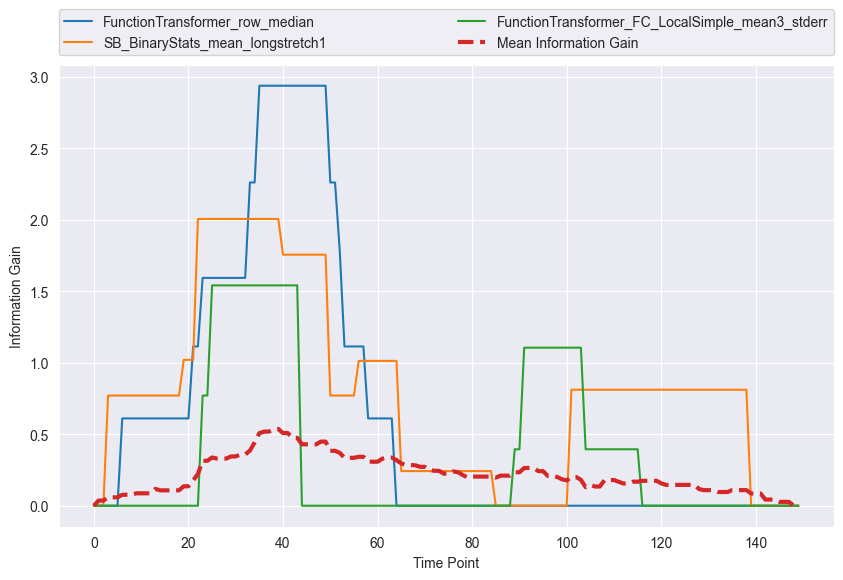

In [34]:
from aeon.visualisation import plot_temporal_importance_curves

names, curves = cif_clf.temporal_importance_curves()
fig, ax = plot_temporal_importance_curves(curves, names, top_curves_shown=3, plot_mean=True)
fig.set_size_inches(10, 6)

In [35]:
from sklearn.metrics import mean_squared_error
from aeon.regression.interval_based import DrCIFRegressor

cif_reg = DrCIFRegressor(n_estimators=20, random_state=42)
cif_reg.fit(X_train_reg, y_train_reg)
cif_preds_r = cif_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, cif_preds_r)

0.7252812729803438

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

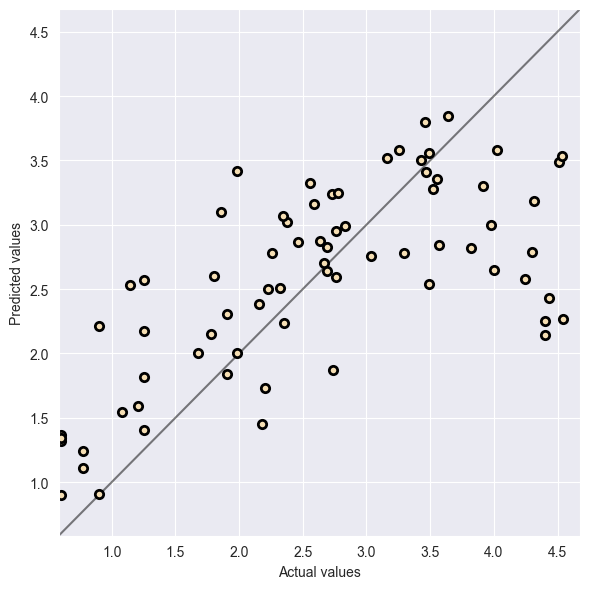

In [36]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, cif_preds_r)

The QUANT interval classifier extracts multiple quantiles from a fixed set of dyadic intervals. The series is continuously halved, with the quantiles from each subseries concatenated to form a feature vector. For each set of intervals extracted, the window is shifted by half the interval length to extract more intervals. Like previous algorithms, multiple series representations are used. The feature extraction is performed on the first order differences, second order differences, and a Fourier transform of the input series along with the original series.

__Note:__ QUANT is implemented using `torch`. You will need to `pip install torch` to run this code.

In [37]:
from aeon.classification.interval_based import QUANTClassifier
from sklearn.metrics import accuracy_score

quant_clf = QUANTClassifier(random_state=42)
quant_clf.fit(X_train_clf, y_train_clf)
quant_clf_pred = quant_clf.predict(X_test_clf)
accuracy_score(y_test_clf, quant_clf_pred)

0.9933333333333333

In [38]:
from aeon.regression.interval_based import QUANTRegressor
from sklearn.metrics import mean_squared_error

quant_reg = QUANTRegressor(random_state=42)
quant_reg.fit(X_train_reg, y_train_reg)
quant_reg_pred = quant_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, quant_reg_pred)

0.7619535834413489

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

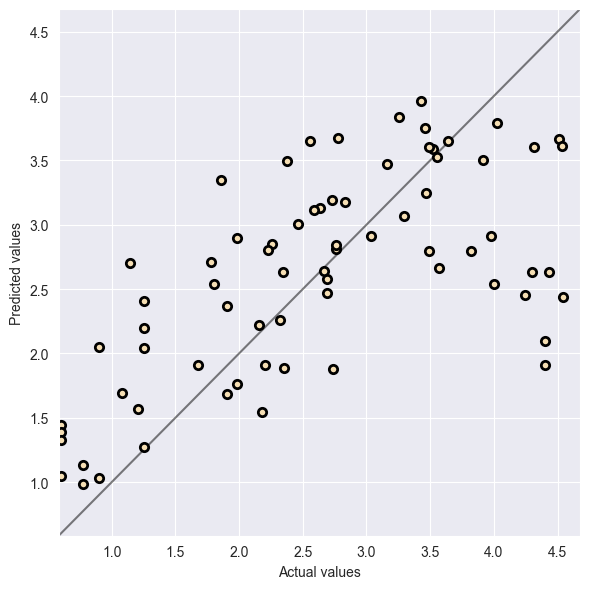

In [39]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, quant_reg_pred)

## Shapelet-based <a id='shapelet'></a>

In this section, our goal is to introduce the use of shapelets for time series machine learning. We provide examples on how to use shapelet-based transformations, classification and regression estimators available in `aeon`. We also show how to use the visualisation tools associated with these estimators.

You can find more information on shapelet-based approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part6_shapelet_based.ipynb) and [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part6_shapelet_based.ipynb).

In [40]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "shapelet"}, as_dataframe=True
)

,name,estimator
0,LearningShapeletClassifier,<class 'aeon.classification.shapelet_based._ls...
1,MrSQMClassifier,<class 'aeon.classification.dictionary_based._...
2,RDSTClassifier,<class 'aeon.classification.shapelet_based._rd...
3,RSASTClassifier,<class 'aeon.classification.shapelet_based._rs...
4,SASTClassifier,<class 'aeon.classification.shapelet_based._sa...
5,ShapeletTransformClassifier,<class 'aeon.classification.shapelet_based._st...


In [41]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "shapelet"}, as_dataframe=True
)

,name,estimator
0,RDSTRegressor,<class 'aeon.regression.shapelet_based._rdst.R...


The shapelet-based (classification) framework is summarised in the image below:

First the $k$ shapelets are generated using the training data (with $k$ a parameter), then, by performing the Shapelet Transform with the generated shapelets and some time series dataset with $n$ samples, we obtain a feature matrix of size $(n,k)$, this matrix is then used by a tabular classifier, such as each sample is described by $k$ features obtained by using the shapelets.

This step shapelet generation and feature extraction can be made using estimators in `aeon.transformation.collection.shapelet_based`, for example, using the `RandomShapeletTransform`.

The the shaplet full pipelines are available in the `ShapeletTransformClassifier` and `RDSTClassifier` classes for classification, and the regressor in the `RDSTRegressorr` class.

<img src="./img/shapelet.png" alt="Shapelet estimator process."><i>

In [42]:
from sklearn.ensemble import RandomForestClassifier
from aeon.classification.shapelet_based import ShapeletTransformClassifier
from sklearn.metrics import accuracy_score

stc = ShapeletTransformClassifier(n_shapelet_samples=2500, estimator=RandomForestClassifier(), random_state=42)
stc.fit(X_train_clf, y_train_clf)
stc_pred = stc.predict(X_test_clf)
accuracy_score(y_test_clf, stc_pred)

1.0

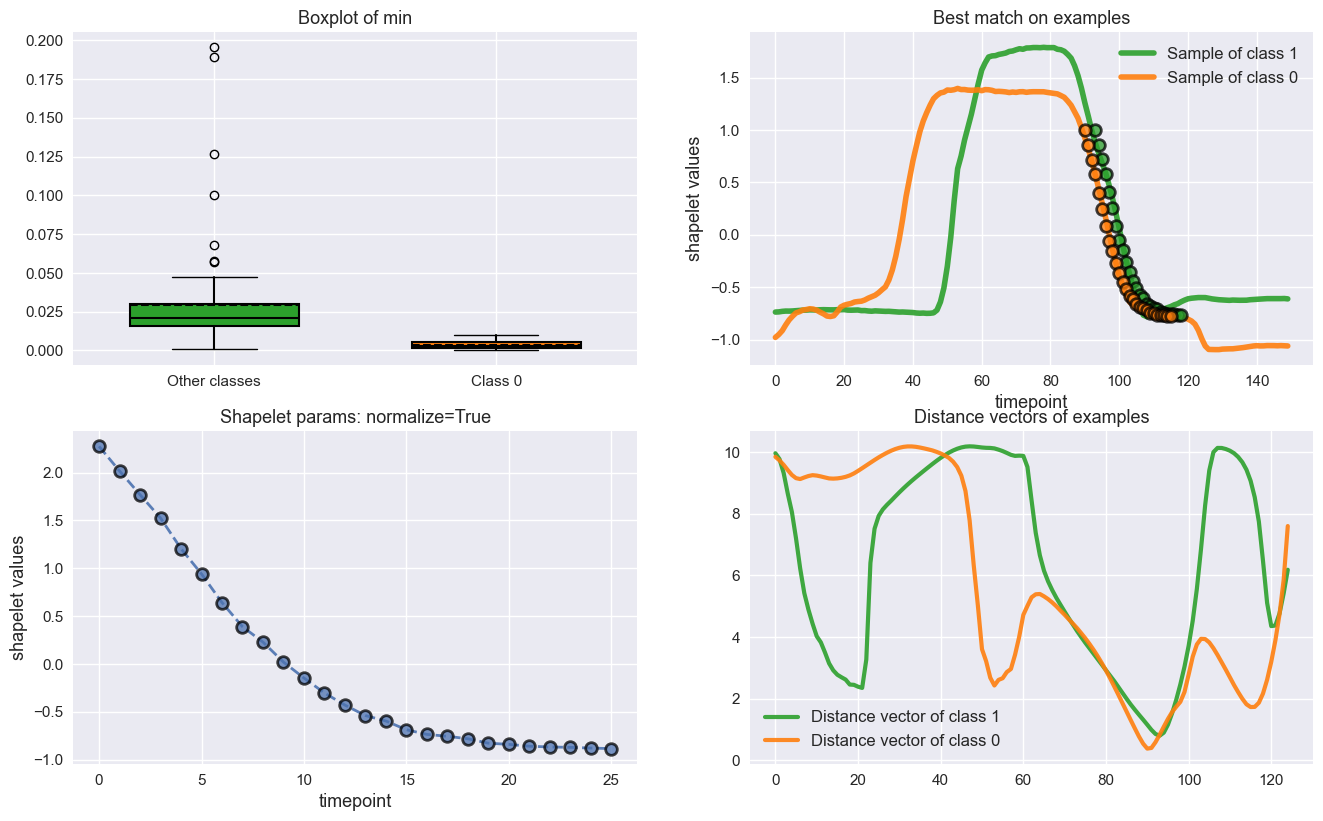

In [43]:
from aeon.visualisation import ShapeletClassifierVisualizer

stc_vis = ShapeletClassifierVisualizer(stc)
id_class = 0 # Show the best shapelet for class 0
fig = stc_vis.visualize_shapelets_one_class(
    X_test_clf,
    y_test_clf,
    id_class,
    figure_options={"figsize": (16,9.5), "nrows": 2, "ncols": 2}, # Some options to make a beatiful plot
    scatter_options={"s": 70,"alpha": 0.75,"zorder": 3,"edgecolor": "black","linewidths": 2}, # Some options to make a beatiful plot
    rc_Params_options={  # Some options to make a beatiful plot
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 13,
},
)

The RDST shapelet extraction process is unsupervised, as such it is easy to apply to regression tasks. The algorithm extracts additional features from time series, as well ass allowing dilated shapelets.

In [44]:
from aeon.classification.shapelet_based import RDSTClassifier
from sklearn.metrics import accuracy_score

rdst_clf = RDSTClassifier(random_state=42)
rdst_clf.fit(X_train_clf, y_train_clf)
rdst_clf_pred = rdst_clf.predict(X_test_clf)
accuracy_score(y_test_clf, rdst_clf_pred)

1.0

In [45]:
from aeon.regression.shapelet_based import RDSTRegressor
from sklearn.metrics import mean_squared_error

rdst_reg = RDSTRegressor(random_state=42)
rdst_reg.fit(X_train_reg, y_train_reg)
rdst_reg_pred = rdst_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, rdst_reg_pred)

0.8136828013824604

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

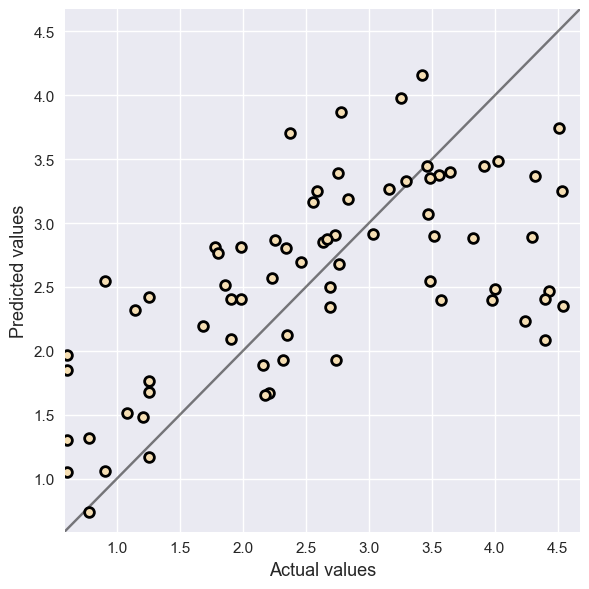

In [46]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, rdst_reg_pred)

## Convolution-based <a id='convolution'></a>

In this notebook, we will explore the convolutional methods for time series machine learning available in `aeon`. Convolutional methods are a class of algorithms that leverage randomly initialised convolutional kernels to extract features from time series data. These methods have been shown to be effective in time series classification tasks, and are very efficient to process.

They are mostly unsupervised and are easily adaptable to regression tasks as well. The regression versions and evaluations of them are unpublished but are available in `aeon`.

You can find more information on convolution-based approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part3_convolution_based.ipynb) and [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part3_convolution_based.ipynb).

<img src="./img/convolution.png" alt="Convolutional based method."><i>

In [47]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "convolution"}, as_dataframe=True
)

,name,estimator
0,Arsenal,<class 'aeon.classification.convolution_based....
1,HydraClassifier,<class 'aeon.classification.convolution_based....
2,MultiRocketHydraClassifier,<class 'aeon.classification.convolution_based....
3,RocketClassifier,<class 'aeon.classification.convolution_based....


In [48]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "convolution"}, as_dataframe=True
)

,name,estimator
0,HydraRegressor,<class 'aeon.regression.convolution_based._hyd...
1,MultiRocketHydraRegressor,<class 'aeon.regression.convolution_based._mr_...
2,RocketRegressor,<class 'aeon.regression.convolution_based._roc...


__Note:__ The Hydra estimators are implemented using `torch`. You will need to `pip install torch` to run them code.

In [49]:
from aeon.classification.convolution_based import RocketClassifier
from sklearn.metrics import accuracy_score

rocket = RocketClassifier(rocket_transform="rocket", random_state=42)
rocket.fit(X_train_clf, y_train_clf)
rocket_preds = rocket.predict(X_test_clf)
accuracy_score(y_test_clf, rocket_preds)

1.0

In [50]:
from aeon.classification.convolution_based import MultiRocketHydraClassifier
from sklearn.metrics import accuracy_score

mrh_clf = MultiRocketHydraClassifier(random_state=42)
mrh_clf.fit(X_train_clf, y_train_clf)
mrh_clf_preds = mrh_clf.predict(X_test_clf)
accuracy_score(y_test_clf, mrh_clf_preds)

1.0

In [51]:
from aeon.regression.convolution_based import MultiRocketHydraRegressor
from sklearn.metrics import mean_squared_error

mrh_reg = MultiRocketHydraRegressor(random_state=42)
mrh_reg.fit(X_train_reg, y_train_reg)
mrh_reg_preds = mrh_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, mrh_reg_preds)

1.0032798249817982

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

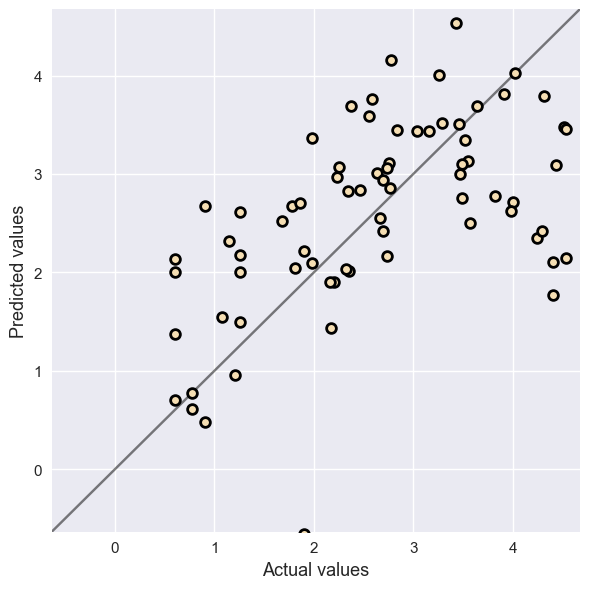

In [52]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, mrh_reg_preds)

## Dictionary-based <a id='dictionary'>

Similar to other subseries extraction algorithms, dictionary approaches identify phase-independent subseries within time series data. These approaches convert each window into a sequence of discrete symbols, commonly referred to as a word. Dictionary methods differentiate themselves by analysing word frequency, a concept often described as a bag-of-words approach. This process can be summarised as follows:

1. Extracting subseries, or windows, from the time series;
2. Converting each window of real values into a discrete-valued word (a sequence of symbols from a fixed alphabet);
3. Constructing a sparse feature vector based on histograms of word counts; and
4. Finally, applying a machine learning classification method to these feature vectors.

Unfortunately, there are no dictionary-based regressors in `aeon` at the moment.

You can find more information on dictionary-based approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part6_dictionary_based.ipynb) and [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part6_dictionary_based.ipynb).

<img src="./img/boss.png" alt="Dictionary based method."><i>

In [53]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "dictionary"}, as_dataframe=True
)

,name,estimator
0,BOSSEnsemble,<class 'aeon.classification.dictionary_based._...
1,ContractableBOSS,<class 'aeon.classification.dictionary_based._...
2,MUSE,<class 'aeon.classification.dictionary_based._...
3,OrdinalTDE,<class 'aeon.classification.ordinal_classifica...
4,REDCOMETS,<class 'aeon.classification.dictionary_based._...
5,TemporalDictionaryEnsemble,<class 'aeon.classification.dictionary_based._...
6,WEASEL,<class 'aeon.classification.dictionary_based._...
7,WEASEL_V2,<class 'aeon.classification.dictionary_based._...


In [54]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "dictionary"}, as_dataframe=True
)

,name,estimator


Transformers for both SAX and SFA used in dictionary-based algorithms are available in `aeon.transformations.collection.dictionary_based`.

In [55]:
from aeon.transformations.collection.dictionary_based import SAX

sax_transformer = SAX(n_segments=20, alphabet_size=10, znormalized=True)
X_train_clf_sax = sax_transformer.fit_transform(X_train_clf)
X_train_clf_sax.shape

(50, 1, 20)

In [56]:
X_train_clf_sax[0,0,:]

array([2, 2, 2, 2, 2, 2, 2, 5, 9, 9, 9, 9, 8, 5, 2, 2, 2, 2, 2, 2],
      dtype=int64)

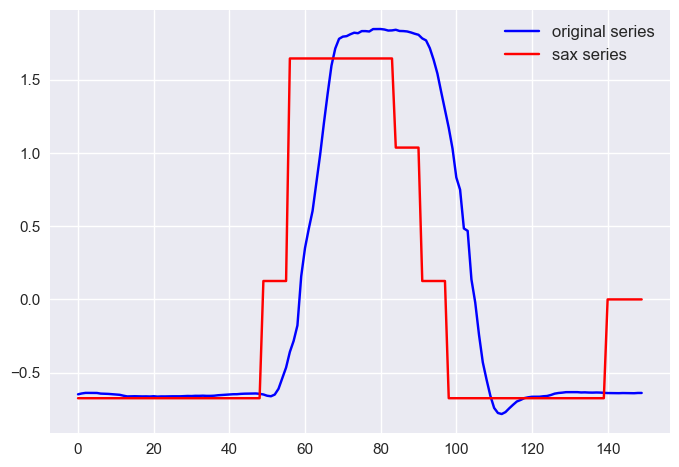

In [57]:
import matplotlib.pyplot as plt

X_train_clf_inv_sax = sax_transformer.inverse_sax(X_train_clf_sax, original_length=int(X_train_clf.shape[-1]))

plt.plot(X_train_clf[0,0,:], color='blue')
plt.plot(X_train_clf_inv_sax[0,0,:], color='red')
plt.legend(["original series", "sax series"])


The temporal dictionary ensemble (TDE) is an ensemble of SFA transforms extending the BOSS dictionary ensemble concept. It makes improvements to the word extraction and ensemble building processes. TDE  uses a spatial pyramid of words to capture the temporal structure of the time series data. Rather than randomly selecting parameters or finding them through a grid search like previous ensembles, TDE uses a Bayesian optimisation inspired approach to select the parameters for its ensemble.


In [58]:
from aeon.classification.dictionary_based import TemporalDictionaryEnsemble
from sklearn.metrics import accuracy_score

tde = TemporalDictionaryEnsemble(random_state=42)
tde.fit(X_train_clf, y_train_clf)
tde_pred = tde.predict(X_test_clf)
accuracy_score(y_test_clf, tde_pred)

1.0

WEASEL is a time series classification pipeline that identifies and retains discriminative words by generating histograms of word counts across various window sizes and lengths. It uses a Chi-squared test for feature selection, discarding non-discriminative words, and then trains a linear Ridge classifier on the selected features. WEASEL also employs a supervised variation of SFA and an information-gain approach to optimizse word creation and class separation.

WEASEL v2.0 is an enhanced version of the original WEASEL classifier that reduces memory usage and improves accuracy by incorporating randomly parameterized SFA transformations and a dilated sliding window approach. This new approach extracts subseries with fixed gaps between values, applies a Fourier transform, and generates words using SFA. Additionally, it introduces a variance-based feature selection strategy to retain only the Fourier values with the highest variance, further optimizing performance.

In [59]:
from aeon.classification.dictionary_based import  WEASEL_V2
from sklearn.metrics import accuracy_score

weasel = WEASEL_V2()
weasel.fit(X_train_clf, y_train_clf)
weasel_pred = weasel.predict(X_test_clf)
accuracy_score(y_test_clf, weasel_pred)

1.0

## Deep learning <a id='deep'></a>

Deep learning is proven to be very effective for Time Series Classification (TSC) tasks, especially convolution based architectures (i.e. FCN and ResNet). A while later, InceptionTime (Convolution based) was proposed to become the new state-of-the-art deep learning model for TSC. We only briefly cover how to use deep learning esiimators in `aeon` in this section. We reccomend looking at the Deep Learning notebook for more information.

You can find more information on deep learning approaches in the KDD tutorial notebook on [GitHub](https://github.com/aeon-tutorials/KDD-2024/blob/main/Notebooks/part6_dictionary_based.ipynb) and [Google Colab](https://colab.research.google.com/github/aeon-tutorials/KDD-2024/blob/main/Notebooks/part6_dictionary_based.ipynb).

__Note:__  All deep learners in `aeon` currently are based on `tensorflow`. You will need to `pip install tensorflow` to run this code.

In [60]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "deeplearning"}, as_dataframe=True
)

,name,estimator
0,CNNClassifier,<class 'aeon.classification.deep_learning._cnn...
1,EncoderClassifier,<class 'aeon.classification.deep_learning._enc...
2,FCNClassifier,<class 'aeon.classification.deep_learning._fcn...
3,InceptionTimeClassifier,<class 'aeon.classification.deep_learning._inc...
4,IndividualInceptionClassifier,<class 'aeon.classification.deep_learning._inc...
5,IndividualLITEClassifier,<class 'aeon.classification.deep_learning._lit...
6,LITETimeClassifier,<class 'aeon.classification.deep_learning._lit...
7,MLPClassifier,<class 'aeon.classification.deep_learning._mlp...
8,ResNetClassifier,<class 'aeon.classification.deep_learning._res...
9,TapNetClassifier,<class 'aeon.classification.deep_learning._tap...


In [61]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "deeplearning"}, as_dataframe=True
)

,name,estimator
0,CNNRegressor,<class 'aeon.regression.deep_learning._cnn.CNN...
1,EncoderRegressor,<class 'aeon.regression.deep_learning._encoder...
2,FCNRegressor,<class 'aeon.regression.deep_learning._fcn.FCN...
3,InceptionTimeRegressor,<class 'aeon.regression.deep_learning._incepti...
4,IndividualInceptionRegressor,<class 'aeon.regression.deep_learning._incepti...
5,IndividualLITERegressor,<class 'aeon.regression.deep_learning._lite_ti...
6,LITETimeRegressor,<class 'aeon.regression.deep_learning._lite_ti...
7,MLPRegressor,<class 'aeon.regression.deep_learning._mlp.MLP...
8,ResNetRegressor,<class 'aeon.regression.deep_learning._resnet....
9,TapNetRegressor,<class 'aeon.regression.deep_learning._tapnet....


In [62]:
from aeon.classification.deep_learning import InceptionTimeClassifier
from sklearn.metrics import accuracy_score

it_clf = InceptionTimeClassifier(n_classifiers=2, n_epochs=500, random_state=42)
it_clf.fit(X_train_clf, y_train_clf)
it_clf_pred = it_clf.predict(X_test_clf)
accuracy_score(y_test_clf, it_clf_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


0.9666666666666667

## Hybrids <a id='hybrid'></a>

Hybrid approaches combine multiple algorithms from the above categories in an attempt to create a more powerful model.

In [63]:
from aeon.registry import all_estimators

all_estimators(
    "classifier", filter_tags={"algorithm_type": "hybrid"}, as_dataframe=True
)

,name,estimator
0,HIVECOTEV1,<class 'aeon.classification.hybrid._hivecote_v...
1,HIVECOTEV2,<class 'aeon.classification.hybrid._hivecote_v...
2,RISTClassifier,<class 'aeon.classification.hybrid._rist.RISTC...


In [64]:
all_estimators(
    "regressor", filter_tags={"algorithm_type": "hybrid"}, as_dataframe=True
)

,name,estimator
0,RISTRegressor,<class 'aeon.regression.hybrid._rist.RISTRegre...


HIVE-COTE v2 is a hybrid ensemble that combines the Arsenal, STC, DrCIF, and TDE algorithms. It uses a weighted voting system to combine the probabilities of the individual classifiers. To save time, we set a 30 second time limit on the runtime in the following cell.

In [65]:
from aeon.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=0.5, random_state=42)
hc2.fit(X_train_clf, y_train_clf)

print("GunPoint accuracy:", hc2.score(X_test_clf, y_test_clf))
print("STC weight = " + str(hc2.stc_weight_))
print("DrCIF weight = " + str(hc2.drcif_weight_))
print("Arsenal weight = " + str(hc2.arsenal_weight_))
print("TDE weight = " + str(hc2.tde_weight_))

GunPoint accuracy: 1.0
STC weight = 1.0
DrCIF weight = 0.7807489599999998
Arsenal weight = 1.0
TDE weight = 1.0


The `ClassifierEnsemble` and `RegressorEnsemble` classes can be used to combine multiple classifiers and regressors of your choosing into an ensemble..

In [66]:
from aeon.classification.interval_based import TimeSeriesForestClassifier
from aeon.classification.convolution_based import RocketClassifier
from aeon.classification.feature_based import FreshPRINCEClassifier
from aeon.classification.compose._ensemble import ClassifierEnsemble
from sklearn.metrics import accuracy_score

ens = [TimeSeriesForestClassifier(), RocketClassifier(), FreshPRINCEClassifier()]
ens_clf = ClassifierEnsemble(ens, weights=[0.2, 0.3, 0.4])
ens_clf.fit(X_train_clf, y_train_clf)
ens_clf_pred = ens_clf.predict(X_test_clf)
accuracy_score(y_test_clf, ens_clf_pred)

1.0

In [67]:
from aeon.regression.interval_based import TimeSeriesForestRegressor
from aeon.regression.convolution_based import RocketRegressor
from aeon.regression.feature_based import FreshPRINCERegressor
from aeon.regression.compose._ensemble import RegressorEnsemble
from sklearn.metrics import mean_squared_error

ens = [TimeSeriesForestRegressor(), RocketRegressor(), FreshPRINCERegressor()]
ens_reg = RegressorEnsemble(ens, weights=[0.2, 0.3, 0.4])
ens_reg.fit(X_train_reg, y_train_reg)
ens_reg_pred = ens_reg.predict(X_test_reg)
mean_squared_error(y_test_reg, ens_reg_pred)

0.8658771192835842

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

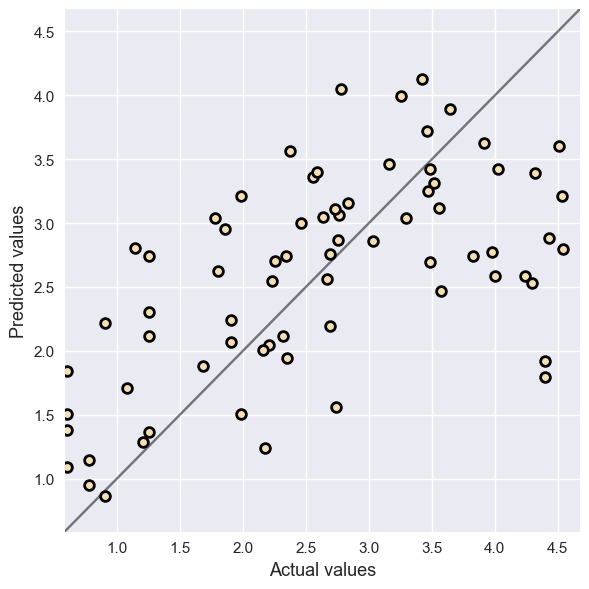

In [68]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_reg, ens_reg_pred)

## Benchmarking <a id='benchmarking'></a>

Below we show the performance of some of the classifiers we have introduced in this notebook on the UCR TSC archive datasets using results from a large scale comparison of TSC algorithms. The results files are stored on [timeseriesclassification.com](timeseriesclassification.com).

While we do not currently have regression results available to loading like this, we hope to add this soon.

In [69]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = [
    "FreshPRINCE",
    "HIVECOTEV2",
    "InceptionTime",
    "WEASEL-D",
    "MR-Hydra",
    "RDST",
    "QUANT",
    "PF", 
    "1NN-DTW",
]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 9)

In [70]:
import numpy as np

np.mean(results, axis=0)

array([0.84159997, 0.87641795, 0.85778229, 0.86050205, 0.86802991,
       0.86311795, 0.85439771, 0.82157013, 0.74206624])

(<Figure size 600x280 with 1 Axes>, <Axes: >)

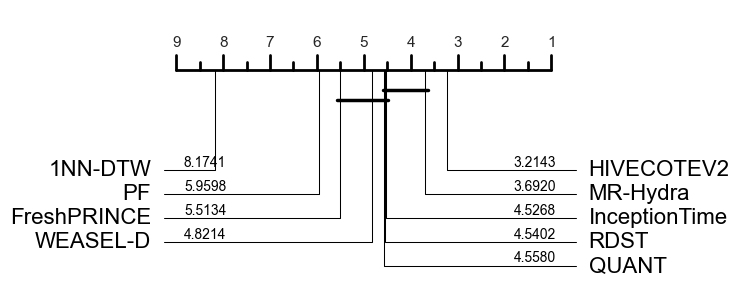

In [71]:
from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

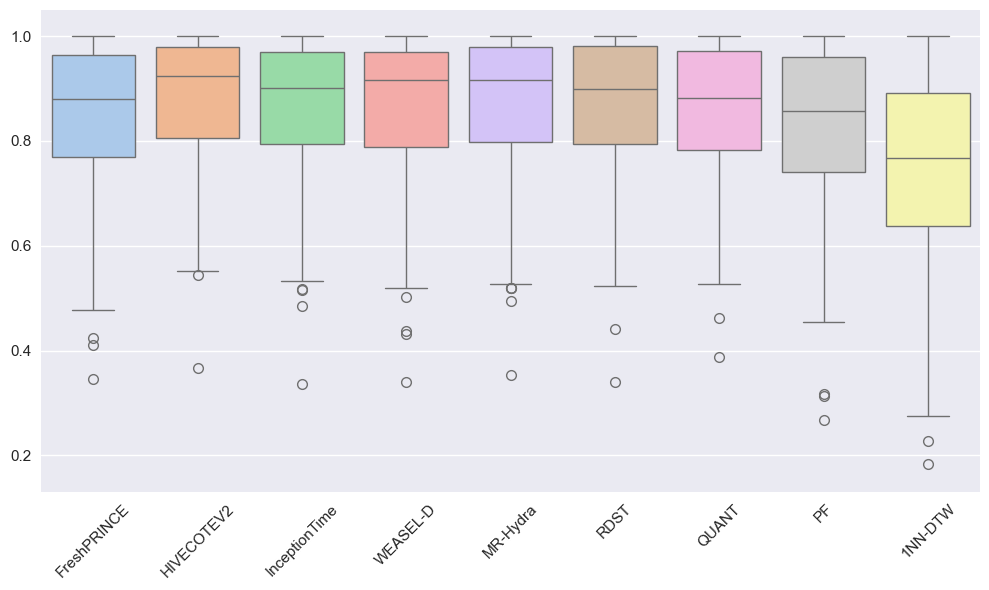

In [72]:
from aeon.visualisation import plot_boxplot

plot_boxplot(results, names, plot_type="boxplot")

## Interfacing with `scikit-learn` utilities <a id='sklearn'></a>

`aeon` classifiers and regressors can be used in `scikit-learn` pipelines and utilities. Below we show how to use them in a pipeline and gridsearch as an example.

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from aeon.transformations.collection.feature_based import Catch22
from aeon.transformations.collection.feature_based import SevenNumberSummaryTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import accuracy_score

pipe = make_pipeline(
    FeatureUnion([("C22", Catch22(replace_nans=True)), ("SNS", SevenNumberSummaryTransformer())]),
    RandomForestClassifier(random_state=42)
)

pipe.fit(X_train_clf, y_train_clf)
pipe_preds = pipe.predict(X_test_clf)
accuracy_score(y_test_clf, pipe_preds)

0.9266666666666666

In [74]:
from aeon.classification.convolution_based import RocketClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = {
    "num_kernels" : [100, 1000, 10000],
    "max_dilations_per_kernel" : [16, 32, 64],
}

gs = GridSearchCV(
    RocketClassifier(rocket_transform="minirocket", random_state=42),
    param_grid,
)
gs.fit(X_train_clf, y_train_clf)
gs_preds = gs.predict(X_test_clf)
accuracy_score(y_test_clf, gs_preds)

1.0

## Further information <a id='further'></a>

There is a lot of information avaiable in the `aeon` documentation:

[`aeon` webpage](https://www.aeon-toolkit.org/en/stable/)

[classification notebook](https://www.aeon-toolkit.org/en/stable/examples/classification/classification.html)

[classification examples](https://www.aeon-toolkit.org/en/stable/examples.html)

[Regression notebook](https://www.aeon-toolkit.org/en/stable/examples/regression/regression.html)

You can get results published in bake offs directly using `aeon`:

[Getting published results directly](https://www.aeon-toolkit.org/en/stable/examples/benchmarking/bakeoff_results.html)

More info on benchmarking:

[benchmarking](https://www.aeon-toolkit.org/en/stable/examples/benchmarking/benchmarking.html)

If you find anything wrong or unclear in the `aeon` documentation, please raise an issue on GitHub or mention it on Slack, we welcome new contributors.